In [160]:
# basic lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning lib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import scienceplots

plt.style.use(['science', 'no-latex', 'grid'])  

# global fontsize
plt.rcParams.update({'font.size': 12})

Dataset shape: (23195, 130)
Countries: 314
Years: 1900 - 2024


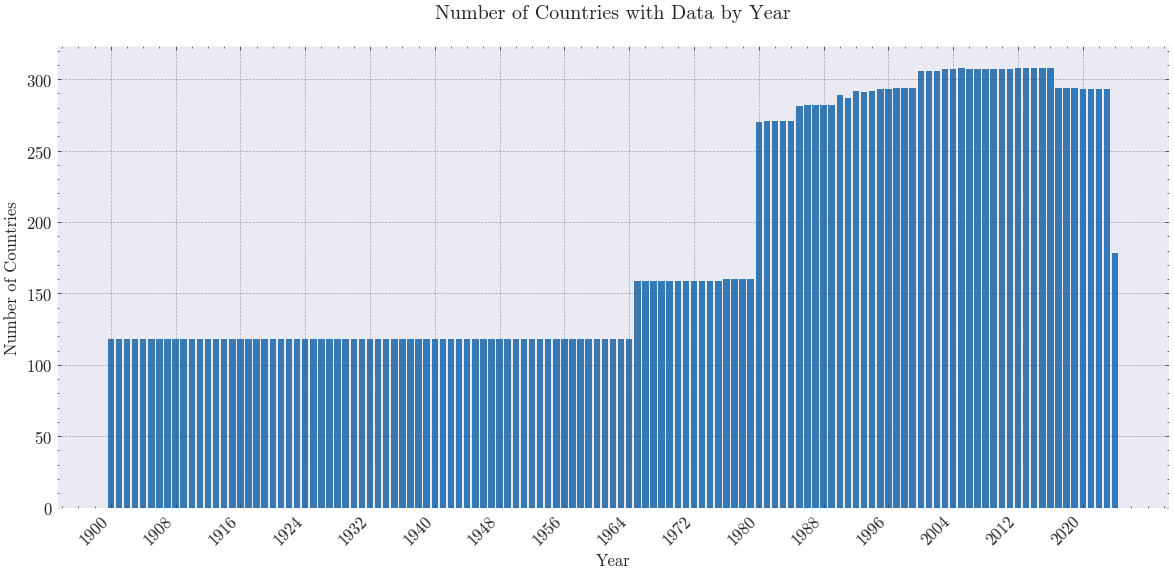

In [161]:
raw_energy_data = pd.read_csv('owid-energy-data.csv')

## basic information
print(f"Dataset shape: {raw_energy_data.shape}")
print(f"Countries: {raw_energy_data['country'].nunique()}")
print(f"Years: {raw_energy_data['year'].min()} - {raw_energy_data['year'].max()}")

yearly_counts = raw_energy_data.groupby('year')['country'].count()

fig, ax = plt.subplots(figsize=(12, 6))

years = yearly_counts.index
counts = yearly_counts.values
bars = ax.bar(years, counts, alpha=0.8)

ax.set_title('Number of Countries with Data by Year', pad=20)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Countries')

step = max(1, len(years) // 15)  
ax.set_xticks(years[::step])
ax.set_xticklabels(years[::step], rotation=45, ha='right')

ax.set_ylim(0, max(counts) * 1.05)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [162]:
## 3. Feature Engineering and Data Quality Control

# Check data completeness for key fields
def check_data_completeness(df, start_year=2010, end_year=2022):
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    completeness = df_period.groupby('country').agg({
        'renewables_share_energy': lambda x: x.notna().sum(),
        'fossil_share_energy': lambda x: x.notna().sum(),
        'energy_per_gdp': lambda x: x.notna().sum(),
        'gdp': lambda x: x.notna().sum()
    }).rename(columns={
        'renewables_share_energy': 'renewable_data_points',
        'fossil_share_energy': 'fossil_data_points',
        'energy_per_gdp': 'energy_intensity_points',
        'gdp': 'gdp_data_points'
    })
    
    return completeness

completeness_df = check_data_completeness(df)

# 3.2 Select only countries with actual energy data
valid_countries = completeness_df[
    (completeness_df['renewable_data_points'] >= 3) & 
    (completeness_df['fossil_data_points'] >= 3)
].index.tolist()


# 3.3 Improved feature engineering function
def create_transition_features(df, valid_countries, start_year=2010, end_year=2022):
    """Process data for valid countries only"""
    
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    # Keep only valid countries
    df_period = df_period[df_period['country'].isin(valid_countries)]
    
    transition_features = []
    
    for country in valid_countries:
        country_data = df_period[df_period['country'] == country].sort_values('year')
        
        if len(country_data) == 0:
            continue
            
        features = {'country': country}
        
        # 1. Renewable energy growth rate (using non-null start and end values)
        renewable_series = country_data['renewables_share_energy'].dropna()
        if len(renewable_series) >= 2:
            start_val = renewable_series.iloc[0]
            end_val = renewable_series.iloc[-1]
            if start_val > 0:
                features['renewable_growth_rate'] = (end_val - start_val) / start_val
            else:
                features['renewable_growth_rate'] = end_val - start_val  # absolute growth
        else:
            features['renewable_growth_rate'] = 0
            
        # 2. Fossil fuel reduction rate
        fossil_series = country_data['fossil_share_energy'].dropna()
        if len(fossil_series) >= 2:
            start_val = fossil_series.iloc[0]
            end_val = fossil_series.iloc[-1]
            if start_val > 0:
                features['fossil_reduction_rate'] = (start_val - end_val) / start_val
            else:
                features['fossil_reduction_rate'] = 0
        else:
            features['fossil_reduction_rate'] = 0
            
        # 3. Energy intensity improvement
        energy_intensity_series = country_data['energy_per_gdp'].dropna()
        if len(energy_intensity_series) >= 2:
            start_val = energy_intensity_series.iloc[0]
            end_val = energy_intensity_series.iloc[-1]
            if start_val > 0:
                features['energy_intensity_improvement'] = (start_val - end_val) / start_val
            else:
                features['energy_intensity_improvement'] = 0
        else:
            features['energy_intensity_improvement'] = 0
            
        # 4. Low carbon energy change
        low_carbon_series = country_data['low_carbon_share_energy'].dropna()
        if len(low_carbon_series) >= 2:
            features['low_carbon_change'] = low_carbon_series.iloc[-1] - low_carbon_series.iloc[0]
        else:
            features['low_carbon_change'] = 0
            
        # 5. Solar and wind energy growth
        solar_series = country_data['solar_share_energy'].fillna(0)
        wind_series = country_data['wind_share_energy'].fillna(0)
        solar_wind_start = solar_series.iloc[0] + wind_series.iloc[0]
        solar_wind_end = solar_series.iloc[-1] + wind_series.iloc[-1]
        features['solar_wind_growth'] = solar_wind_end - solar_wind_start
        
        # 6. Current state (using latest non-null values)
        latest_renewable = country_data['renewables_share_energy'].dropna()
        features['current_renewable_share'] = latest_renewable.iloc[-1] if len(latest_renewable) > 0 else 0
        
        latest_fossil = country_data['fossil_share_energy'].dropna()
        features['current_fossil_share'] = latest_fossil.iloc[-1] if len(latest_fossil) > 0 else 100
        
        latest_per_capita = country_data['energy_per_capita'].dropna()
        features['current_energy_per_capita'] = latest_per_capita.iloc[-1] if len(latest_per_capita) > 0 else 0
        
        # 7. GDP per capita
        gdp_series = country_data['gdp'].dropna()
        pop_series = country_data['population'].dropna()
        if len(gdp_series) > 0 and len(pop_series) > 0:
            latest_gdp = gdp_series.iloc[-1]
            latest_pop = pop_series.iloc[-1]
            features['gdp_per_capita'] = latest_gdp / latest_pop if latest_pop > 0 else 0
        else:
            features['gdp_per_capita'] = 0
            
        transition_features.append(features)
    
    return pd.DataFrame(transition_features)

# 3.4 Create clean feature dataframe
transition_df = create_transition_features(df, valid_countries)

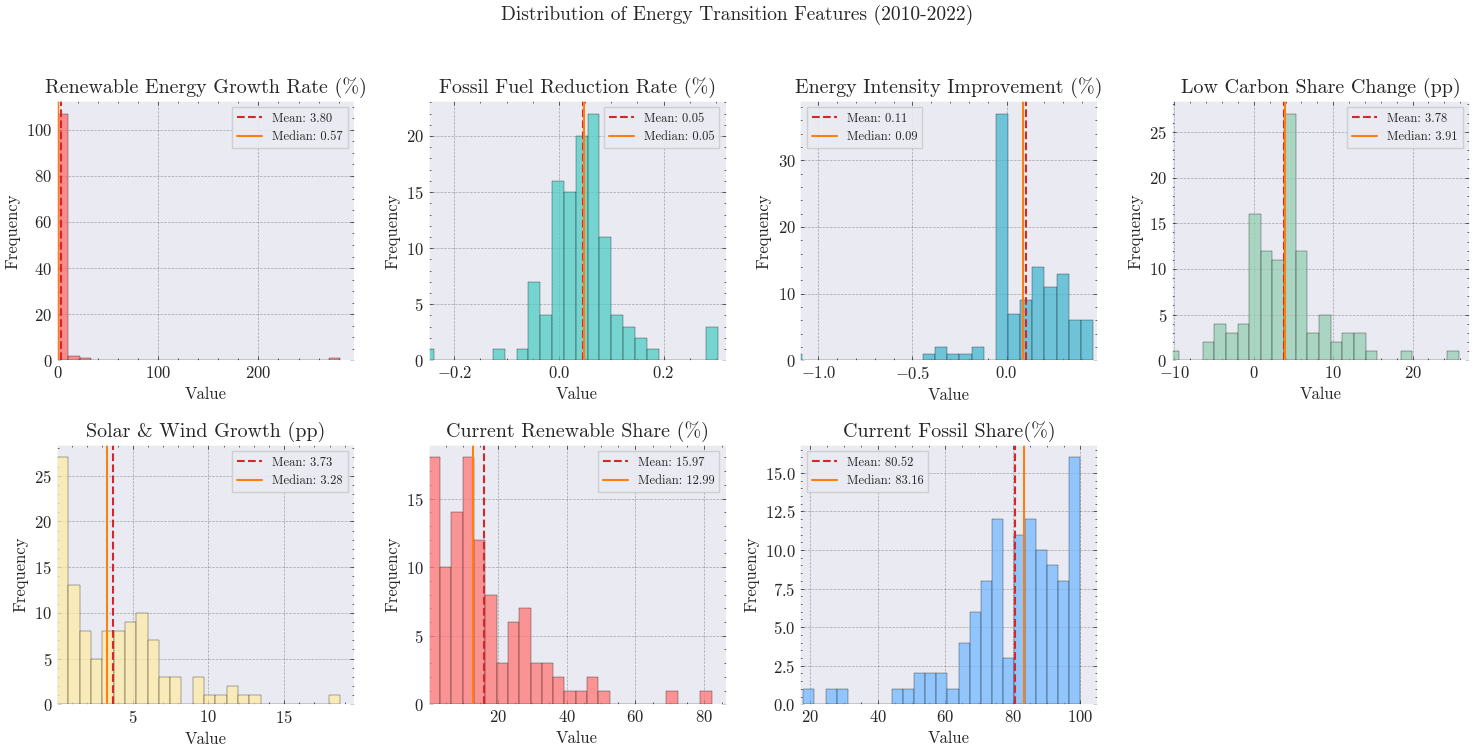

In [163]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  
axes = axes.ravel()

for i, col in enumerate(X):
    data = transition_df[col].dropna()
    mean_val = data.mean()
    median_val = data.median()
    
    n, bins, patches = axes[i].hist(data, bins=25, alpha=0.75, 
                                   color=colors[i], edgecolor='black', 
                                   linewidth=0.3, density=False)
    
    axes[i].axvline(mean_val, color='#d62728', linestyle='--', 
                   linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='#ff7f0e', linestyle='-', 
                   linewidth=1.5, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(feature_names[col])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    
    axes[i].legend(fontsize=9, frameon=True, fancybox=False, 
                  shadow=False, framealpha=0.9)
    
    axes[i].grid(alpha=0.3)
    axes[i].set_xlim(data.min() * 0.95, data.max() * 1.05)

fig.delaxes(axes[7])
plt.suptitle('Distribution of Energy Transition Features (2010-2022)', fontsize=14, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [164]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Create a dataframe with scaled features
X_scaled_df = pd.DataFrame(
    X_scaled, 
    columns=clustering_features, 
    index=transition_df.index
)

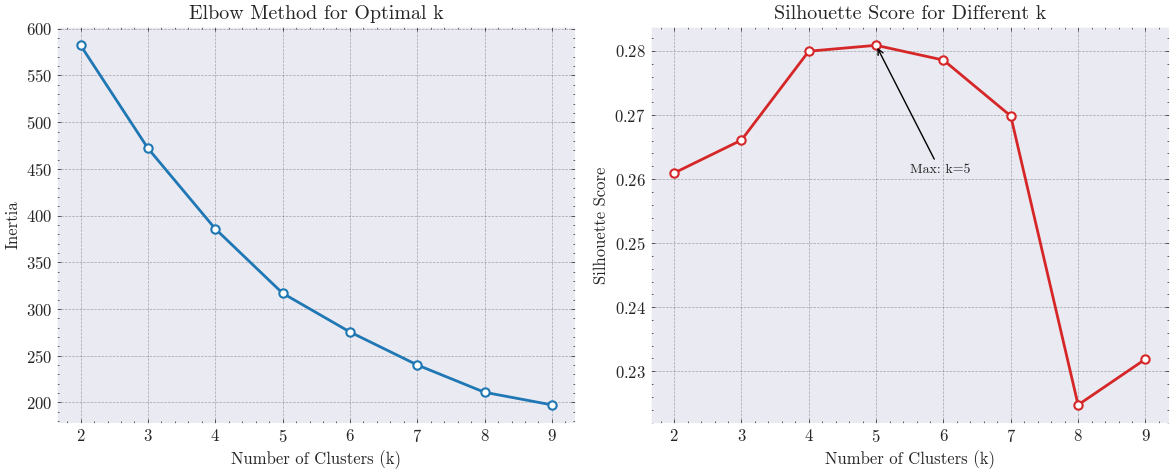

In [165]:
## 5. K-means Clustering
# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Method plot
ax1.plot(K, inertias, 'o-', color='#1f77b4', linewidth=2, 
         markersize=6, markerfacecolor='white', markeredgewidth=1.5)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.set_xticks(K)
ax1.grid(alpha=0.3)

# Silhouette Score plot
ax2.plot(K, silhouette_scores, 'o-', color='#d62728', linewidth=2,
         markersize=6, markerfacecolor='white', markeredgewidth=1.5)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.set_xticks(K)
ax2.grid(alpha=0.3)

# 添加最优k值标注
optimal_k_silhouette = K[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)
ax2.annotate(f'Max: k={optimal_k_silhouette}', 
            xy=(optimal_k_silhouette, max_silhouette),
            xytext=(optimal_k_silhouette+0.5, max_silhouette-0.02),
            arrowprops=dict(arrowstyle='->', color='black', lw=1),
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

K-means clustering completed with 4 clusters

Cluster sizes:
kmeans_cluster
0    58
1     4
2     1
3    48
Name: count, dtype: int64


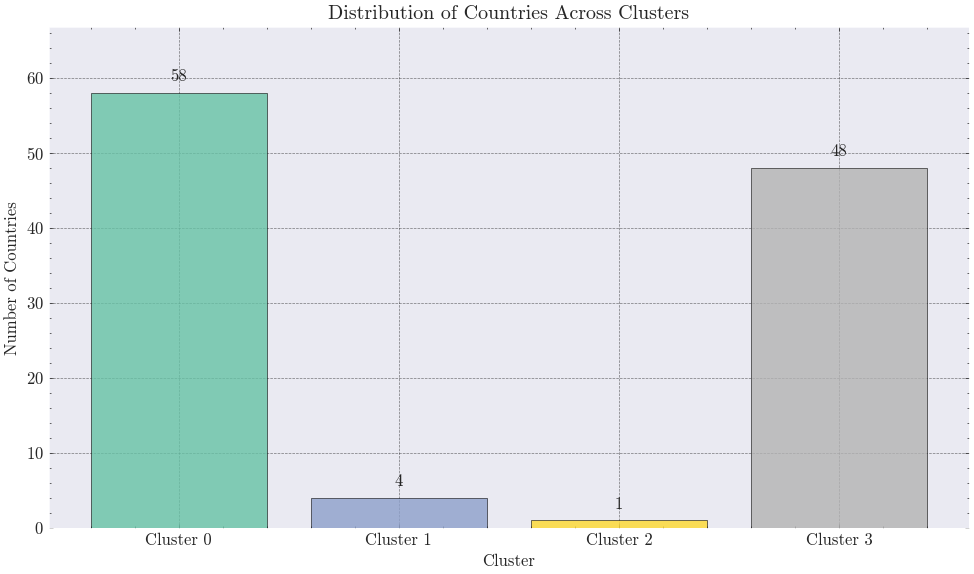


Detailed Cluster Statistics:
Total countries clustered: 111
Cluster 0: 58 countries (52.3%)
Cluster 1: 4 countries (3.6%)
Cluster 2: 1 countries (0.9%)
Cluster 3: 48 countries (43.2%)

 Cluster Feature Visualization:
----------------------------------------


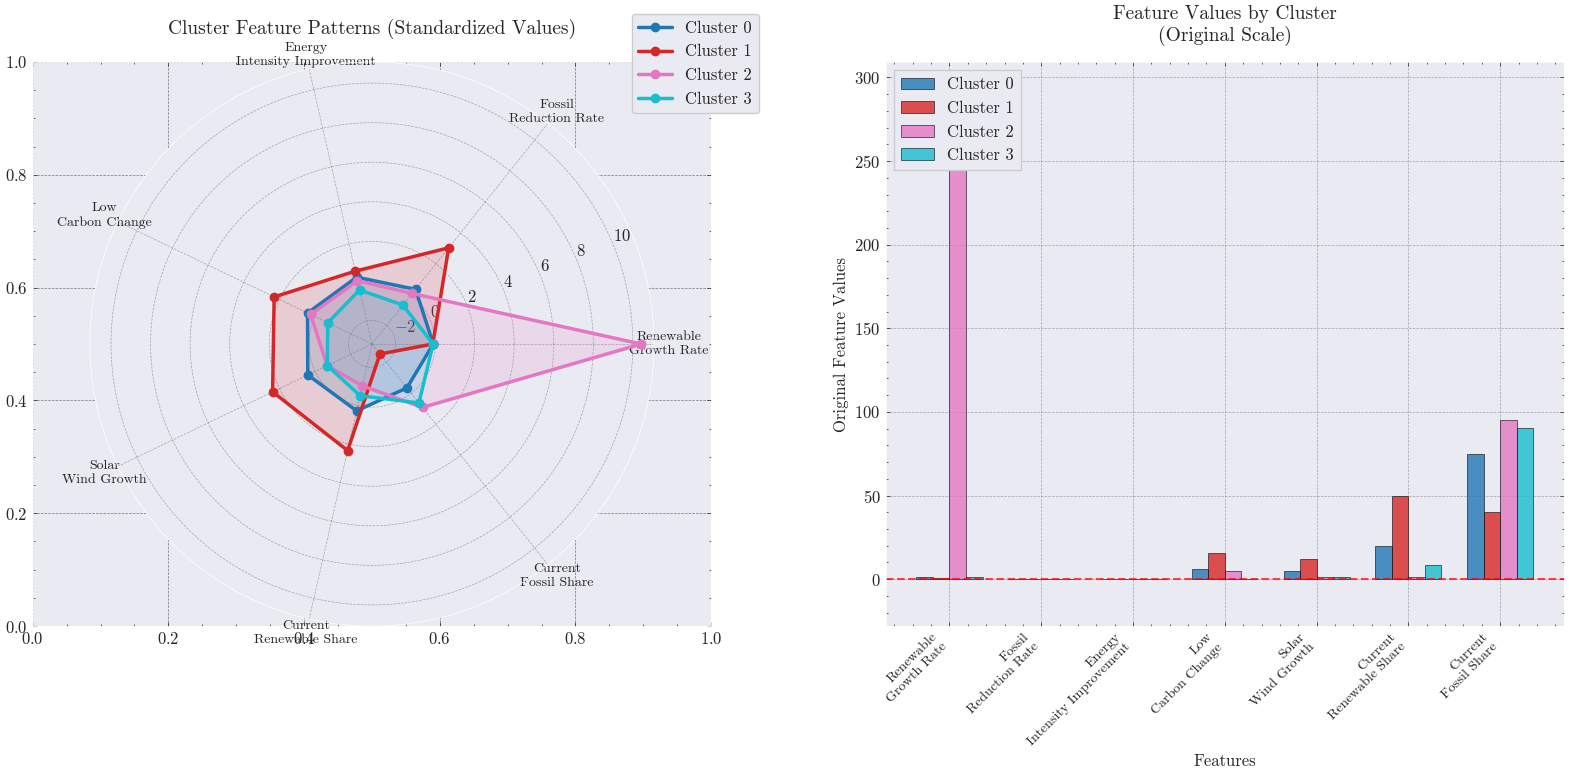

In [182]:
# 你现有的聚类代码...
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
transition_df['kmeans_cluster'] = kmeans_labels

print(f"K-means clustering completed with {optimal_k} clusters")
print("\nCluster sizes:")
cluster_counts = transition_df['kmeans_cluster'].value_counts().sort_index()
print(cluster_counts)

fig, ax = plt.subplots(figsize=(10, 6))
clusters = cluster_counts.index
sizes = cluster_counts.values

colors = plt.cm.Set2(np.linspace(0, 1, len(clusters)))

bars = ax.bar(range(len(clusters)), sizes, alpha=0.8, color=colors, 
              edgecolor='black', linewidth=0.5)

ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Countries')
ax.set_title('Distribution of Countries Across Clusters')

cluster_labels = [f'Cluster {i}' for i in clusters]
ax.set_xticks(range(len(clusters)))
ax.set_xticklabels(cluster_labels)

for i, (bar, size) in enumerate(zip(bars, sizes)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.02,
            f'{size}', ha='center', va='bottom', fontweight='bold')

ax.set_ylim(0, max(sizes) * 1.15)
plt.tight_layout()
plt.show()

print(f"\nDetailed Cluster Statistics:")
print(f"Total countries clustered: {len(transition_df)}")
for cluster in sorted(clusters):
    percentage = (cluster_counts[cluster] / len(transition_df)) * 100
    print(f"Cluster {cluster}: {cluster_counts[cluster]} countries ({percentage:.1f}%)")

n_clusters = optimal_k
clustering_features = X.columns.tolist()  
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=clustering_features)
original_centers = pd.DataFrame(
    scaler.inverse_transform(centers), 
    columns=clustering_features
)

print(f"\n Cluster Feature Visualization:")
print("-" * 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

angles = np.linspace(0, 2 * np.pi, len(clustering_features), endpoint=False).tolist()
angles += angles[:1]  

ax1 = plt.subplot(1, 2, 1, projection='polar')

colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    values = centers_df.iloc[i].values.tolist()
    values += values[:1]  
    
    ax1.plot(angles, values, 'o-', linewidth=2.5, markersize=6,
            label=f'Cluster {i}', color=colors[i])
    ax1.fill(angles, values, alpha=0.15, color=colors[i])

ax1.set_xticks(angles[:-1])
feature_labels = []
for feat in clustering_features:
    label = feat.replace('_', ' ').title()
    if len(label) > 15:
        words = label.split()
        if len(words) > 1:
            mid = len(words) // 2
            label = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    feature_labels.append(label)

ax1.set_xticklabels(feature_labels, fontsize=10)
ax1.set_title('Cluster Feature Patterns (Standardized Values)', 
             pad=20, fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), frameon=True)
ax1.grid(True, alpha=0.3)

x = np.arange(len(clustering_features))
width = 0.18  # 稍微调宽条形

all_values = []
for i in range(n_clusters):
    all_values.extend(original_centers.iloc[i].values)
min_val = min(all_values)
max_val = max(all_values)

for i in range(n_clusters):
    values = original_centers.iloc[i].values
    ax2.bar(x + i*width, values, width, label=f'Cluster {i}', 
           color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('Original Feature Values', fontsize=12, fontweight='bold')
ax2.set_title('Feature Values by Cluster\n(Original Scale)', 
             fontsize=14, fontweight='bold', pad=15)

# 改进x轴标签
ax2.set_xticks(x + width * (n_clusters-1) / 2)
x_labels = []
for feat in clustering_features:
    label = feat.replace('_', ' ').title()
    if len(label) > 12:
        words = label.split()
        if len(words) > 1:
            mid = len(words) // 2
            label = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
    x_labels.append(label)

ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
    
ax2.legend(frameon=True, fancybox=False, shadow=False, 
          loc='upper left', bbox_to_anchor=(0, 1))

y_padding = (max_val - min_val) * 0.1
ax2.set_ylim(min_val - y_padding, max_val + y_padding)

if min_val < 0:
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [167]:
## Safe Isolation Forest Outlier Detection
print("=== Safe Isolation Forest Outlier Detection ===\n")

# 1. Apply Isolation Forest with optimal parameters
contamination_rate = 0.10  # 10% outliers
iso_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_estimators=200,
    max_samples='auto'
)

# Fit and predict
outlier_labels = iso_forest.fit_predict(X_scaled)
anomaly_scores = iso_forest.decision_function(X_scaled)

# Add results to dataframe safely
transition_df_copy = transition_df.copy()
transition_df_copy['is_outlier'] = (outlier_labels == -1)
transition_df_copy['anomaly_score'] = anomaly_scores

n_outliers = np.sum(outlier_labels == -1)
outlier_ratio = n_outliers / len(outlier_labels)

print(f"Isolation Forest Results:")
print(f"Number of outliers: {n_outliers} ({outlier_ratio:.1%})")
print(f"Number of normal countries: {len(outlier_labels) - n_outliers}")

# 2. Identify outlier countries
outlier_countries = transition_df_copy[transition_df_copy['is_outlier']]['country'].tolist()
print(f"\nOutlier Countries:")
for i, country in enumerate(sorted(outlier_countries), 1):
    score = transition_df_copy[transition_df_copy['country'] == country]['anomaly_score'].iloc[0]
    print(f"{i:2d}. {country:<25} (anomaly score: {score:6.3f})")

# 3. Detailed feature analysis
print(f"\n=== Feature Analysis ===")

# Calculate statistics for outliers vs normal
outlier_data = transition_df_copy[transition_df_copy['is_outlier']][clustering_features]
normal_data = transition_df_copy[~transition_df_copy['is_outlier']][clustering_features]

print(f"\nFeature Comparison (Outliers vs Normal):")
print(f"{'Feature':<28} {'Outlier Mean':<12} {'Normal Mean':<12} {'Difference':<12}")
print("-" * 70)

for feature in clustering_features:
    outlier_mean = outlier_data[feature].mean()
    normal_mean = normal_data[feature].mean()
    difference = outlier_mean - normal_mean
    direction = "↑" if difference > 0 else "↓"
    
    print(f"{feature:<28} {outlier_mean:>10.3f} {normal_mean:>10.3f} {difference:>10.3f} {direction}")

# 4. Top outliers analysis
print(f"\n=== Top 5 Most Anomalous Countries ===")

outlier_details = transition_df_copy[transition_df_copy['is_outlier']].copy()
outlier_details = outlier_details.sort_values('anomaly_score')  # Most anomalous first

for idx, (_, country_data) in enumerate(outlier_details.head().iterrows(), 1):
    print(f"\n{idx}. {country_data['country']} (anomaly score: {country_data['anomaly_score']:.3f})")
    
    # Show key characteristics
    print("   Key characteristics:")
    for feature in clustering_features:
        value = country_data[feature]
        normal_mean = normal_data[feature].mean()
        normal_std = normal_data[feature].std()
        z_score = (value - normal_mean) / normal_std if normal_std > 0 else 0
        
        if abs(z_score) > 1.5:  # Highlight extreme values
            direction = "very high" if z_score > 0 else "very low"
            print(f"     - {feature.replace('_', ' ').title()}: {direction} ({z_score:+.1f}σ)")

=== Safe Isolation Forest Outlier Detection ===

Isolation Forest Results:
Number of outliers: 11 (9.9%)
Number of normal countries: 100

Outlier Countries:
 1. Azerbaijan                (anomaly score: -0.013)
 2. Denmark                   (anomaly score: -0.187)
 3. Finland                   (anomaly score: -0.092)
 4. Iceland                   (anomaly score: -0.153)
 5. Norway                    (anomaly score: -0.080)
 6. Other CIS (EI)            (anomaly score: -0.037)
 7. Other South America (EI)  (anomaly score: -0.161)
 8. Sweden                    (anomaly score: -0.128)
 9. United Arab Emirates      (anomaly score: -0.124)
10. United Kingdom            (anomaly score: -0.040)
11. Venezuela                 (anomaly score: -0.050)

=== Feature Analysis ===

Feature Comparison (Outliers vs Normal):
Feature                      Outlier Mean Normal Mean  Difference  
----------------------------------------------------------------------
renewable_growth_rate            26.248   

In [168]:
# Create cluster profiles
def create_cluster_profiles(df, cluster_col, features):
    """Create statistical profiles for each cluster"""
    profiles = []
    
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:  # Skip noise points for DBSCAN
            continue
            
        cluster_data = df[df[cluster_col] == cluster]
        profile = {'cluster': cluster, 'size': len(cluster_data)}
        
        # Calculate statistics for each feature
        for feature in features:
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_std'] = cluster_data[feature].std()
        
        # Get example countries
        profile['example_countries'] = ', '.join(cluster_data['country'].head(5).tolist())
        
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Create profiles for K-means clusters
kmeans_profiles = create_cluster_profiles(transition_df, 'kmeans_cluster', clustering_features)
print("K-means Cluster Profiles:")
kmeans_profiles

K-means Cluster Profiles:


,cluster,size,renewable_growth_rate_mean,renewable_growth_rate_std,fossil_reduction_rate_mean,fossil_reduction_rate_std,energy_intensity_improvement_mean,energy_intensity_improvement_std,low_carbon_change_mean,low_carbon_change_std,solar_wind_growth_mean,solar_wind_growth_std,current_renewable_share_mean,current_renewable_share_std,current_fossil_share_mean,current_fossil_share_std,example_countries
0,0,58,1.394366,3.165690,0.069847,0.038056,0.163180,0.159961,5.931069,3.337194,5.136517,2.889060,19.938379,12.341875,74.925690,12.296006,"Asia, Asia Pacific (EI), Australia, Austria, B..."
1,1,4,0.757525,0.713482,0.261775,0.079935,0.228614,0.084657,15.409750,9.096673,11.913250,5.148885,49.442750,15.314634,40.313000,14.998966,"Denmark, Finland, Norway, Sweden"
2,2,1,281.200000,NaN,0.050633,NaN,0.125504,NaN,5.063000,NaN,1.403000,NaN,1.411000,NaN,94.932000,NaN,United Arab Emirates
3,3,48,1.172714,2.925652,-0.002943,0.052674,0.025009,0.243986,0.193667,3.358418,1.393292,1.478032,8.695479,10.577215,90.339958,10.708029,"Africa, Africa (EI), Algeria, Argentina, Azerb..."


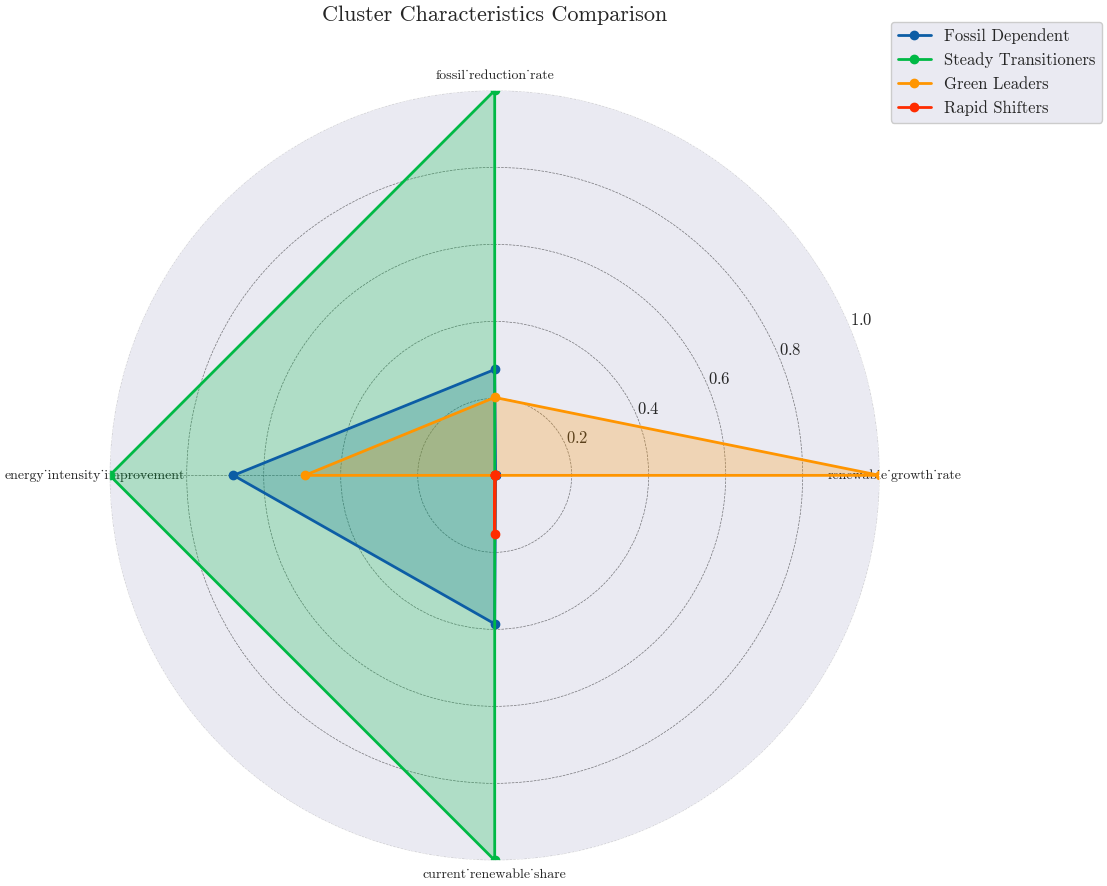

In [169]:
# Visualize cluster characteristics with radar chart
from math import pi

def create_radar_chart(df, cluster_col, features, cluster_names=None):
    """Create radar chart for cluster characteristics"""
    
    # Calculate mean values for each cluster
    cluster_means = df.groupby(cluster_col)[features].mean()
    
    # Normalize to 0-1 scale for radar chart
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    
    # Set up the radar chart
    categories = features
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot each cluster
    for idx, (cluster, values) in enumerate(cluster_means_norm.iterrows()):
        if cluster == -1:  # Skip noise points
            continue
            
        values = values.tolist()
        values += values[:1]
        
        cluster_name = cluster_names[cluster] if cluster_names else f'Cluster {cluster}'
        ax.plot(angles, values, 'o-', linewidth=2, label=cluster_name)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    ax.set_ylim(0, 1)
    ax.set_title('Cluster Characteristics Comparison', size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    return fig

# Define cluster names based on characteristics
cluster_names = {
    0: 'Fossil Dependent',
    1: 'Steady Transitioners',
    2: 'Green Leaders',
    3: 'Rapid Shifters'
}

# Create radar chart
radar_fig = create_radar_chart(transition_df, 'kmeans_cluster', ['renewable_growth_rate', 'fossil_reduction_rate', 'energy_intensity_improvement', 'current_renewable_share'], cluster_names)
plt.show()

In [170]:
# Classify countries as developed/developing based on GDP per capita
# Using World Bank threshold: $12,000 GDP per capita
gdp_threshold = 12000
transition_df['development_status'] = transition_df['gdp_per_capita'].apply(
    lambda x: 'Developed' if x >= gdp_threshold else 'Developing'
)

# Handle missing GDP data
transition_df.loc[transition_df['gdp_per_capita'].isna(), 'development_status'] = 'Unknown'

print("Development status distribution:")
print(transition_df['development_status'].value_counts())

Development status distribution:
development_status
Developed     66
Developing    45
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

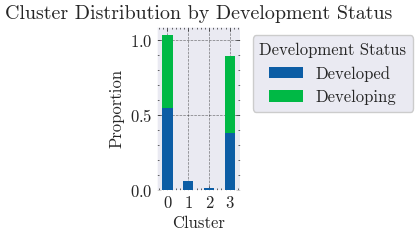

In [171]:
# Analyze cluster distribution by development status
cluster_dev_crosstab = pd.crosstab(transition_df['kmeans_cluster'], transition_df['development_status'], normalize='columns')

# Visualize
plt.figure(figsize=(10, 6))
cluster_dev_crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Distribution by Development Status')
plt.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

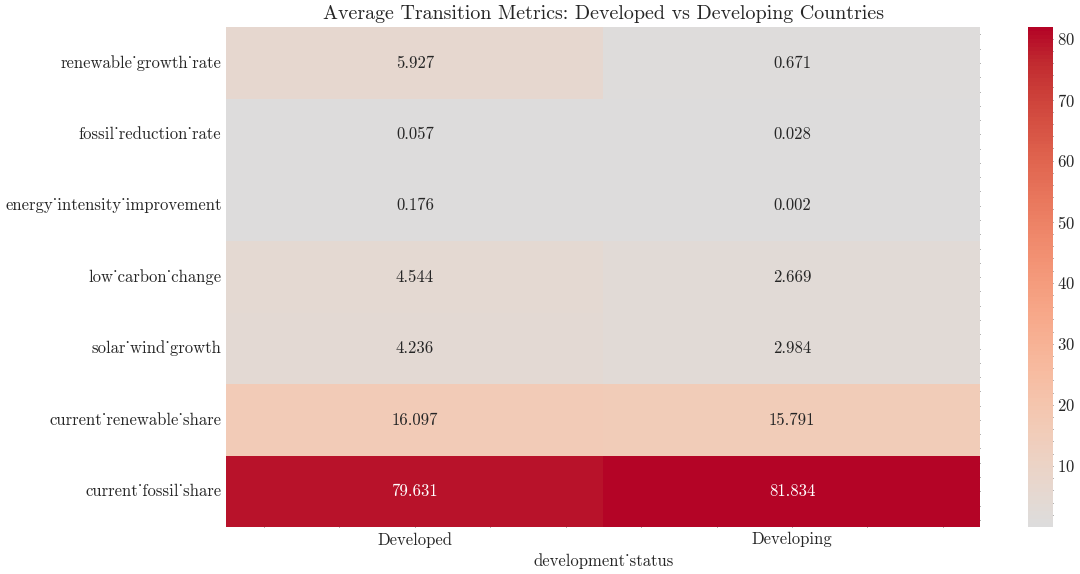

In [172]:
# Statistical comparison between developed and developing countries
dev_comparison = transition_df[transition_df['development_status'].isin(['Developed', 'Developing'])].groupby('development_status')[clustering_features].mean()

# Create comparison heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(dev_comparison.T, annot=True, fmt='.3f', cmap='coolwarm', center=0)
plt.title('Average Transition Metrics: Developed vs Developing Countries')
plt.tight_layout()
plt.show()

In [173]:
# Create summary report
def create_summary_report(df, cluster_col='kmeans_cluster'):
    """Create a comprehensive summary of transition patterns"""
    
    print("=== ENERGY TRANSITION PATTERN ANALYSIS SUMMARY ===\n")
    
    # 1. Overall patterns
    print("1. IDENTIFIED TRANSITION PATTERNS:")
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:
            continue
        cluster_countries = df[df[cluster_col] == cluster]
        cluster_name = cluster_names.get(cluster, f"Cluster {cluster}")
        print(f"\n{cluster_name} ({len(cluster_countries)} countries):")
        print(f"  - Average renewable share: {cluster_countries['current_renewable_share'].mean():.1f}%")
        print(f"  - Average fossil reduction: {cluster_countries['fossil_reduction_rate'].mean():.1%}")
        print(f"  - Example countries: {', '.join(cluster_countries['country'].head(3).tolist())}")
    
    # 2. Development divide
    print("\n\n2. DEVELOPED vs DEVELOPING COUNTRIES:")
    dev_stats = df[df['development_status'].isin(['Developed', 'Developing'])].groupby('development_status').agg({
        'renewable_growth_rate': 'mean',
        'fossil_reduction_rate': 'mean',
        'current_renewable_share': 'mean'
    })
    print(dev_stats)
    
    # 3. Policy recommendations
    print("\n\n3. KEY INSIGHTS FOR POLICY:")
    print("  - Green Leaders show that >80% renewable energy is achievable")
    print("  - Rapid Shifters demonstrate that fast transition is possible with right policies")
    print("  - Developing countries need different support than developed nations")
    print("  - Special attention needed for Fossil Dependent countries")

# Generate summary report
create_summary_report(transition_df)

=== ENERGY TRANSITION PATTERN ANALYSIS SUMMARY ===

1. IDENTIFIED TRANSITION PATTERNS:

Fossil Dependent (58 countries):
  - Average renewable share: 19.9%
  - Average fossil reduction: 7.0%
  - Example countries: Asia, Asia Pacific (EI), Australia

Steady Transitioners (4 countries):
  - Average renewable share: 49.4%
  - Average fossil reduction: 26.2%
  - Example countries: Denmark, Finland, Norway

Green Leaders (1 countries):
  - Average renewable share: 1.4%
  - Average fossil reduction: 5.1%
  - Example countries: United Arab Emirates

Rapid Shifters (48 countries):
  - Average renewable share: 8.7%
  - Average fossil reduction: -0.3%
  - Example countries: Africa, Africa (EI), Algeria


2. DEVELOPED vs DEVELOPING COUNTRIES:
                    renewable_growth_rate  fossil_reduction_rate  \
development_status                                                 
Developed                        5.927383               0.057030   
Developing                       0.670808             

In [174]:
# Export results for further analysis
output_df = transition_df[['country', 'kmeans_cluster', 'development_status'] + clustering_features]
output_df['cluster_name'] = output_df['kmeans_cluster'].map(cluster_names)

# Save to CSV
output_df.to_csv('energy_transition_clusters.csv', index=False)
print("\nResults saved to 'energy_transition_clusters.csv'")

# Display final clustering results
print("\nFinal clustering results (first 20 countries):")
output_df.head(20)


Results saved to 'energy_transition_clusters.csv'

Final clustering results (first 20 countries):


,country,kmeans_cluster,development_status,renewable_growth_rate,fossil_reduction_rate,energy_intensity_improvement,low_carbon_change,solar_wind_growth,current_renewable_share,current_fossil_share,cluster_name
0,Africa,3,Developing,0.324228,0.019574,0.000000,1.810,1.593,8.920,90.661,Rapid Shifters
1,Africa (EI),3,Developing,0.324228,0.019574,0.000000,1.810,1.593,8.920,90.661,Rapid Shifters
2,Algeria,3,Developed,1.111111,0.001201,-0.264887,0.120,0.217,0.228,99.772,Rapid Shifters
3,Argentina,3,Developed,0.082762,0.007134,-0.042743,0.619,4.217,12.010,86.146,Rapid Shifters
4,Asia,0,Developing,1.025413,0.059558,0.000000,5.479,4.157,11.397,86.515,Fossil Dependent
5,Asia Pacific (EI),0,Developing,1.071019,0.069329,0.000000,6.305,4.812,13.006,84.638,Fossil Dependent
6,Australia,0,Developed,2.240460,0.095494,0.186430,9.159,9.047,13.247,86.753,Fossil Dependent
7,Austria,0,Developed,0.166739,0.071845,0.230707,5.021,5.877,35.134,64.866,Fossil Dependent
8,Azerbaijan,3,Developed,-0.688363,-0.051979,-0.347191,-4.833,0.167,2.188,97.812,Rapid Shifters
9,Bangladesh,3,Developing,-0.169065,-0.001422,0.049363,-0.141,0.262,0.693,99.307,Rapid Shifters
